In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
import re

%matplotlib inline

# Movie Recommendation System

This notebook implements a comprehensive movie recommendation system similar to the book recommendation system, with multiple approaches:

1. **Popularity-based recommendations** using weighted ratings
2. **Content-based filtering** using movie features (genre, director, country)
3. **Genre-based recommendations**
4. **Collaborative filtering** (when user rating data is available)

The system will be used to create an API and Streamlit application.

## Load and Explore Data

In [5]:
# Load movie data
movies = pd.read_csv("movies.csv")
print(f"Dataset shape: {movies.shape}")
print("\nFirst few movies:")
movies.head()

Dataset shape: (250, 7)

First few movies:


,id,Название,Год,Рейтинг,Страна,Жанр,Режиссёр
0,535341,1+1,2011,8.3,Франция,драма,Оливье Накаш
1,258687,Интерстеллар,2014,8.3,США,фантастика,Кристофер Нолан
2,326,Побег из Шоушенка,1994,8.2,США,драма,Фрэнк Дарабонт
3,1143242,Джентльмены,2019,8.2,США,криминал,Гай Ричи
4,435,Зеленая миля,1999,8.1,США,драма,Фрэнк Дарабонт


In [6]:
# Data exploration
print("Dataset info:")
movies.info()
print(f"\nUnique genres: {movies['Жанр'].nunique()}")
print(f"Unique directors: {movies['Режиссёр'].nunique()}")
print(f"Unique countries: {movies['Страна'].nunique()}")
print(f"Year range: {movies['Год'].min()} - {movies['Год'].max()}")
print(f"Rating range: {movies['Рейтинг'].min()} - {movies['Рейтинг'].max()}")

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        250 non-null    int64  
 1   Название  250 non-null    object 
 2   Год       250 non-null    int64  
 3   Рейтинг   250 non-null    float64
 4   Страна    250 non-null    object 
 5   Жанр      250 non-null    object 
 6   Режиссёр  250 non-null    object 
dtypes: float64(1), int64(2), object(4)
memory usage: 13.8+ KB

Unique genres: 20
Unique directors: 173
Unique countries: 19
Year range: 1939 - 2025
Rating range: 7.2 - 8.3


In [7]:
# Clean and prepare data
movies_clean = movies.copy()

# Clean movie titles
movies_clean["Название"] = movies_clean["Название"].apply(lambda x: re.sub("[\W_]+", " ", x).strip())

# Fill missing values
movies_clean = movies_clean.fillna('Unknown')

# Convert rating to numeric
movies_clean['Рейтинг'] = pd.to_numeric(movies_clean['Рейтинг'], errors='coerce')

print("Cleaned data:")
movies_clean.head()

Cleaned data:


<>:5: SyntaxWarning: invalid escape sequence '\W'
<>:5: SyntaxWarning: invalid escape sequence '\W'
C:\Users\user\AppData\Local\Temp\ipykernel_26032\2128283780.py:5: SyntaxWarning: invalid escape sequence '\W'
  movies_clean["Название"] = movies_clean["Название"].apply(lambda x: re.sub("[\W_]+", " ", x).strip())


,id,Название,Год,Рейтинг,Страна,Жанр,Режиссёр
0,535341,1 1,2011,8.3,Франция,драма,Оливье Накаш
1,258687,Интерстеллар,2014,8.3,США,фантастика,Кристофер Нолан
2,326,Побег из Шоушенка,1994,8.2,США,драма,Фрэнк Дарабонт
3,1143242,Джентльмены,2019,8.2,США,криминал,Гай Ричи
4,435,Зеленая миля,1999,8.1,США,драма,Фрэнк Дарабонт


## 1. Popularity-Based Recommendation System

This system recommends movies based on their popularity using weighted ratings, similar to IMDB's Top 250.

In [8]:
def get_popular_movies(movies_df, top_n=10):
    """
    Get top popular movies using weighted rating formula (similar to IMDB Top 250)
    """
    # Since we don't have vote counts, we'll use a simplified approach
    # based on rating and assume equal weight for all movies
    
    # Create a popularity score (you can modify this if you have vote count data)
    movies_df = movies_df.copy()
    
    # Sort by rating (highest first)
    popular_movies = movies_df.sort_values('Рейтинг', ascending=False).head(top_n)
    
    return popular_movies[['Название', 'Год', 'Рейтинг', 'Жанр', 'Режиссёр', 'Страна']].reset_index(drop=True)

# Get top 10 popular movies
top_popular = get_popular_movies(movies_clean, 10)
print("Top 10 Popular Movies:")
top_popular

Top 10 Popular Movies:


,Название,Год,Рейтинг,Жанр,Режиссёр,Страна
0,1 1,2011,8.3,драма,Оливье Накаш,Франция
1,Интерстеллар,2014,8.3,фантастика,Кристофер Нолан,США
2,Побег из Шоушенка,1994,8.2,драма,Фрэнк Дарабонт,США
3,Джентльмены,2019,8.2,криминал,Гай Ричи,США
4,Зеленая миля,1999,8.1,драма,Фрэнк Дарабонт,США
5,Остров проклятых,2009,8.1,триллер,Мартин Скорсезе,США
6,Властелин колец Возвращение короля,2003,8.1,фэнтези,Питер Джексон,Новая Зеландия
7,Форрест Гамп,1994,8.1,драма,Роберт Земекис,США
8,Терминатор 2 Судный день,1991,8.0,фантастика,Джеймс Кэмерон,США
9,Зеленая книга,2018,8.0,биография,Питер Фаррелли,США


C:\Users\user\AppData\Local\Temp\ipykernel_26032\1601743441.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_popular, x='Рейтинг', y='Название', palette='viridis')


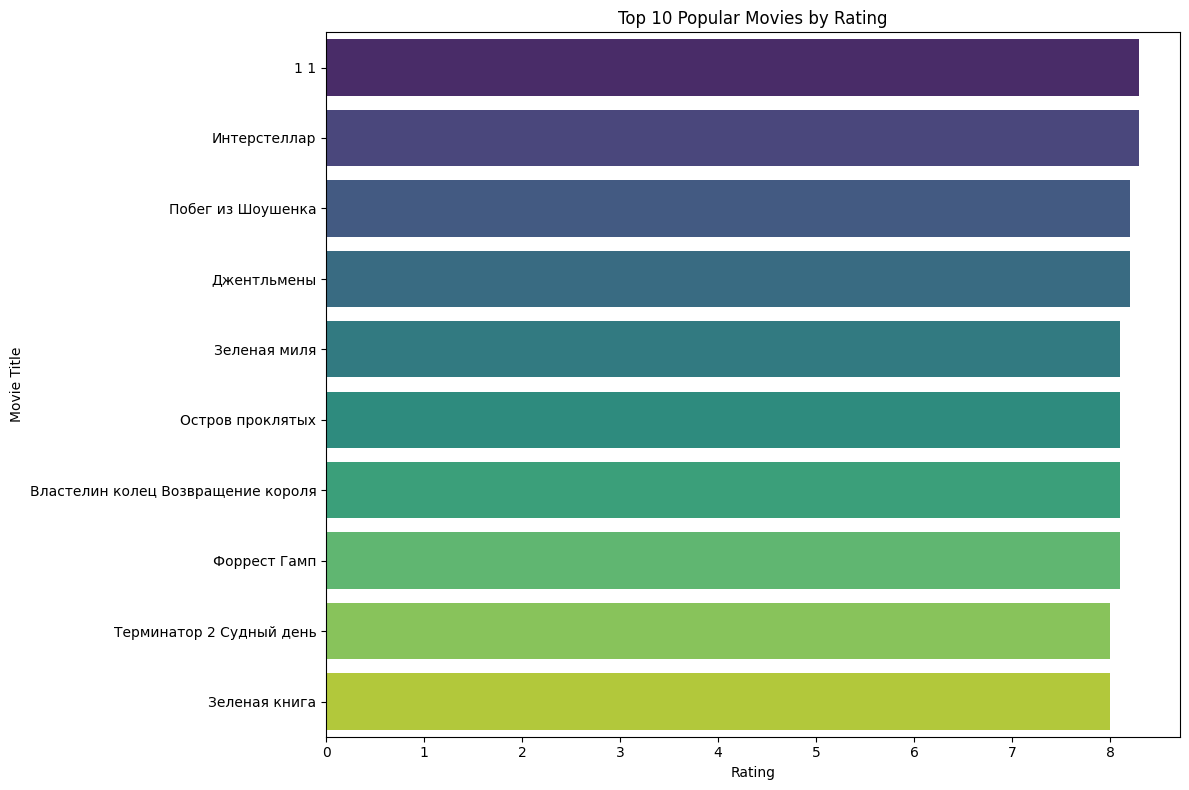

In [9]:
# Visualize top popular movies
plt.figure(figsize=(12, 8))
sns.barplot(data=top_popular, x='Рейтинг', y='Название', palette='viridis')
plt.title('Top 10 Popular Movies by Rating')
plt.xlabel('Rating')
plt.ylabel('Movie Title')
plt.tight_layout()
plt.show()

## 2. Genre-Based Recommendation System

This system recommends top movies from a specific genre.

In [10]:
def get_movies_by_genre(movies_df, genre, top_n=10):
    """
    Get top movies from a specific genre
    """
    # Filter movies by genre (case insensitive)
    genre_movies = movies_df[movies_df['Жанр'].str.contains(genre, case=False, na=False)]
    
    if genre_movies.empty:
        return pd.DataFrame()  # Return empty DataFrame if no movies found
    
    # Sort by rating and return top recommendations
    top_movies = genre_movies.sort_values('Рейтинг', ascending=False).head(top_n)
    
    return top_movies[['Название', 'Год', 'Рейтинг', 'Жанр', 'Режиссёр', 'Страна']].reset_index(drop=True)

# Get available genres
available_genres = movies_clean['Жанр'].value_counts()
print("Available genres:")
print(available_genres.head(10))
print(f"\nTotal unique genres: {len(available_genres)}")

Available genres:
Жанр
драма         86
фантастика    22
фэнтези       22
триллер       19
боевик        14
криминал      13
комедия       13
мелодрама     12
военный        9
мультфильм     8
Name: count, dtype: int64

Total unique genres: 20


In [11]:
# Test genre-based recommendations
test_genre = "драма"
drama_movies = get_movies_by_genre(movies_clean, test_genre, 10)
print(f"Top 10 {test_genre} movies:")
drama_movies

Top 10 драма movies:


,Название,Год,Рейтинг,Жанр,Режиссёр,Страна
0,1 1,2011,8.3,драма,Оливье Накаш,Франция
1,Побег из Шоушенка,1994,8.2,драма,Фрэнк Дарабонт,США
2,Зеленая миля,1999,8.1,драма,Фрэнк Дарабонт,США
3,Форрест Гамп,1994,8.1,драма,Роберт Земекис,США
4,Унесённые ветром,1939,7.9,мелодрама,Виктор Флеминг,США
5,Достучаться до небес,1997,7.9,драма,Томас Ян,Германия
6,Список Шиндлера,1993,7.9,драма,Стивен Спилберг,США
7,Девчата,1961,7.8,мелодрама,Юрий Чулюкин,СССР
8,Волк с Уолл стрит,2013,7.8,драма,Мартин Скорсезе,США
9,Брат,1997,7.8,драма,Алексей Балабанов,Россия


## 3. Content-Based Recommendation System

This system recommends movies based on movie features like genre, director, and country using TF-IDF and cosine similarity.

In [12]:
def prepare_content_features(movies_df):
    """
    Prepare content features for content-based filtering
    """
    movies_df = movies_df.copy()
    
    # Create content features by combining genre, director, and country
    movies_df['content_features'] = (
        movies_df['Жанр'].astype(str) + ' ' + 
        movies_df['Режиссёр'].astype(str) + ' ' + 
        movies_df['Страна'].astype(str)
    )
    
    return movies_df

def get_content_based_recommendations(movies_df, movie_name, top_n=10):
    """
    Get movie recommendations based on content similarity
    """
    # Prepare content features
    movies_prepared = prepare_content_features(movies_df)
    
    # Check if movie exists
    if movie_name not in movies_prepared['Название'].values:
        return pd.DataFrame(), f"Movie '{movie_name}' not found in the dataset"
    
    # Create TF-IDF matrix
    tfidf = TfidfVectorizer(stop_words=None, lowercase=True, max_features=1000)
    tfidf_matrix = tfidf.fit_transform(movies_prepared['content_features'])
    
    # Calculate cosine similarity
    cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
    
    # Get index of the movie
    movie_idx = movies_prepared[movies_prepared['Название'] == movie_name].index[0]
    
    # Get similarity scores for all movies
    sim_scores = list(enumerate(cosine_sim[movie_idx]))
    
    # Sort movies by similarity score
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get top similar movies (excluding the input movie)
    movie_indices = [i[0] for i in sim_scores[1:top_n+1]]
    
    # Return recommended movies with their features
    recommendations = movies_prepared.iloc[movie_indices][['Название', 'Год', 'Жанр', 'Режиссёр', 'Страна', 'Рейтинг']]
    
    # Add similarity scores
    similarity_scores = [i[1] for i in sim_scores[1:top_n+1]]
    recommendations = recommendations.copy()
    recommendations['similarity_score'] = similarity_scores
    
    return recommendations.reset_index(drop=True), None

# Test content-based recommendations
test_movie = "Интерстеллар"
content_recs, error = get_content_based_recommendations(movies_clean, test_movie, 10)
if error:
    print(error)
else:
    print(f"Movies similar to '{test_movie}':")
    print(content_recs)

Movies similar to 'Интерстеллар':
                            Название   Год        Жанр         Режиссёр  \
0                             Начало  2010  фантастика  Кристофер Нолан   
1                      Темный рыцарь  2008  фантастика  Кристофер Нолан   
2  Темный рыцарь Возрождение легенды  2012  фантастика  Кристофер Нолан   
3                            Престиж  2006     триллер  Кристофер Нолан   
4           Терминатор 2 Судный день  1991  фантастика   Джеймс Кэмерон   
5                             Аватар  2009  фантастика   Джеймс Кэмерон   
6                         Терминатор  1984  фантастика   Джеймс Кэмерон   
7                    Назад в будущее  1985  фантастика   Роберт Земекис   
8                  Назад в будущее 2  1989  фантастика   Роберт Земекис   
9                  Дюна Часть вторая  2024  фантастика     Дени Вильнёв   

           Страна  Рейтинг  similarity_score  
0             США      8.0          1.000000  
1             США      7.8          1.000000  

## 4. Collaborative Filtering Recommendation System

This system will be implemented when user rating data is available. For now, we'll create a placeholder that can be extended.

In [13]:
def get_collaborative_recommendations(movies_df, movie_name, top_n=10):
    """
    Collaborative filtering recommendations (placeholder)
    Since we don't have user rating data, we'll use a simplified approach
    based on similar genres and directors
    """
    # Check if movie exists
    if movie_name not in movies_df['Название'].values:
        return pd.DataFrame(), f"Movie '{movie_name}' not found in the dataset"
    
    # Get the target movie's features
    target_movie = movies_df[movies_df['Название'] == movie_name].iloc[0]
    target_genre = target_movie['Жанр']
    target_director = target_movie['Режиссёр']
    
    # Find movies with same genre or director
    similar_movies = movies_df[
        (movies_df['Жанр'] == target_genre) | 
        (movies_df['Режиссёр'] == target_director)
    ]
    
    # Remove the target movie itself
    similar_movies = similar_movies[similar_movies['Название'] != movie_name]
    
    # Sort by rating and return top recommendations
    recommendations = similar_movies.sort_values('Рейтинг', ascending=False).head(top_n)
    
    return recommendations[['Название', 'Год', 'Жанр', 'Режиссёр', 'Страна', 'Рейтинг']].reset_index(drop=True), None

# Test collaborative filtering (simplified)
test_movie = "1+1"
collab_recs, error = get_collaborative_recommendations(movies_clean, test_movie, 10)
if error:
    print(error)
else:
    print(f"Collaborative recommendations for '{test_movie}':")
    print(collab_recs)

Movie '1+1' not found in the dataset


## 5. Complete Movie Recommendation System Class

This class combines all recommendation methods into a single interface that will be used by the API.

In [14]:
class MovieRecommendationSystem:
    def __init__(self, movies_csv_path="movies.csv"):
        """Initialize the recommendation system"""
        self.movies_df = pd.read_csv(movies_csv_path)
        self._prepare_data()
        
    def _prepare_data(self):
        """Clean and prepare the movie data"""
        # Clean movie titles
        self.movies_df["Название"] = self.movies_df["Название"].apply(lambda x: re.sub("[\W_]+", " ", x).strip())
        
        # Fill missing values
        self.movies_df = self.movies_df.fillna('Unknown')
        
        # Convert rating to numeric
        self.movies_df['Рейтинг'] = pd.to_numeric(self.movies_df['Рейтинг'], errors='coerce')
        
        print(f"Loaded {len(self.movies_df)} movies")
        
    def get_popular_movies(self, top_n=10):
        """Get top popular movies based on ratings"""
        popular_movies = self.movies_df.sort_values('Рейтинг', ascending=False).head(top_n)
        return popular_movies[['Название', 'Год', 'Рейтинг', 'Жанр', 'Режиссёр', 'Страна']].reset_index(drop=True)
    
    def get_movies_by_genre(self, genre, top_n=10):
        """Get top movies from a specific genre"""
        genre_movies = self.movies_df[self.movies_df['Жанр'].str.contains(genre, case=False, na=False)]
        
        if genre_movies.empty:
            return pd.DataFrame()
        
        top_movies = genre_movies.sort_values('Рейтинг', ascending=False).head(top_n)
        return top_movies[['Название', 'Год', 'Рейтинг', 'Жанр', 'Режиссёр', 'Страна']].reset_index(drop=True)
    
    def get_content_based_recommendations(self, movie_name, top_n=10):
        """Get content-based recommendations"""
        return get_content_based_recommendations(self.movies_df, movie_name, top_n)
    
    def get_collaborative_recommendations(self, movie_name, top_n=10):
        """Get collaborative filtering recommendations"""
        return get_collaborative_recommendations(self.movies_df, movie_name, top_n)
    
    def get_available_genres(self):
        """Get list of available genres"""
        return sorted(self.movies_df['Жанр'].unique())
    
    def get_movie_names(self):
        """Get list of all movie names"""
        return sorted(self.movies_df['Название'].unique())
    
    def search_movies(self, query):
        """Search movies by name"""
        query = query.lower()
        matches = self.movies_df[self.movies_df['Название'].str.lower().str.contains(query, na=False)]
        return matches[['Название', 'Год', 'Рейтинг', 'Жанр', 'Режиссёр', 'Страна']].reset_index(drop=True)

# Initialize the recommendation system
rec_system = MovieRecommendationSystem()
print("Movie Recommendation System initialized successfully!")

Loaded 250 movies
Movie Recommendation System initialized successfully!


<>:10: SyntaxWarning: invalid escape sequence '\W'
<>:10: SyntaxWarning: invalid escape sequence '\W'
C:\Users\user\AppData\Local\Temp\ipykernel_26032\1745479741.py:10: SyntaxWarning: invalid escape sequence '\W'
  self.movies_df["Название"] = self.movies_df["Название"].apply(lambda x: re.sub("[\W_]+", " ", x).strip())


## 6. Test All Recommendation Methods

In [15]:
# Test all recommendation methods
print("="*50)
print("1. TOP 10 POPULAR MOVIES:")
print("="*50)
popular = rec_system.get_popular_movies(10)
print(popular.to_string(index=False))

print("\n" + "="*50)
print("2. TOP 10 DRAMA MOVIES:")
print("="*50)
drama = rec_system.get_movies_by_genre("драма", 10)
print(drama.to_string(index=False))

print("\n" + "="*50)
print("3. CONTENT-BASED RECOMMENDATIONS (similar to 'Интерстеллар'):")
print("="*50)
content_recs, error = rec_system.get_content_based_recommendations("Интерстеллар", 10)
if error:
    print(error)
else:
    print(content_recs.to_string(index=False))

print("\n" + "="*50)
print("4. COLLABORATIVE FILTERING RECOMMENDATIONS (for '1+1'):")
print("="*50)
collab_recs, error = rec_system.get_collaborative_recommendations("1+1", 10)
if error:
    print(error)
else:
    print(collab_recs.to_string(index=False))

1. TOP 10 POPULAR MOVIES:
                          Название  Год  Рейтинг       Жанр        Режиссёр         Страна
                               1 1 2011      8.3      драма    Оливье Накаш        Франция
                      Интерстеллар 2014      8.3 фантастика Кристофер Нолан            США
                 Побег из Шоушенка 1994      8.2      драма  Фрэнк Дарабонт            США
                       Джентльмены 2019      8.2   криминал        Гай Ричи            США
                      Зеленая миля 1999      8.1      драма  Фрэнк Дарабонт            США
                  Остров проклятых 2009      8.1    триллер Мартин Скорсезе            США
Властелин колец Возвращение короля 2003      8.1    фэнтези   Питер Джексон Новая Зеландия
                      Форрест Гамп 1994      8.1      драма  Роберт Земекис            США
          Терминатор 2 Судный день 1991      8.0 фантастика  Джеймс Кэмерон            США
                     Зеленая книга 2018      8.0  биография  Пит